## Выбор архитектуры
### ResNet


[Imagewoof](https://github.com/fastai/imagenette#imagewoof) является подмножеством ImageNet из 10 пород собак. [Leaderboard](https://github.com/fastai/imagenette#imagenette-leaderboard) представлен различными вариациями ResNet. В курсе [Walk with fastai](https://walkwithfastai.com/) есть урок [XResNet and ImageWoof](https://walkwithfastai.com/ImageWoof), где показано, как применить техники, повышающие точность ResNet на этом датасете. Загрузим данные и проверим, как это работает.

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGEWOOF)

In [3]:
items = get_image_files(path)
items

(#12954) [Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_55.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_3717.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_326.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/ILSVRC2012_val_00001777.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_3136.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_1266.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_5357.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_1519.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_6463.JPEG'),Path('/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_3583.JPEG')...]

Посмотрим, как выглядят размеченные изображения:

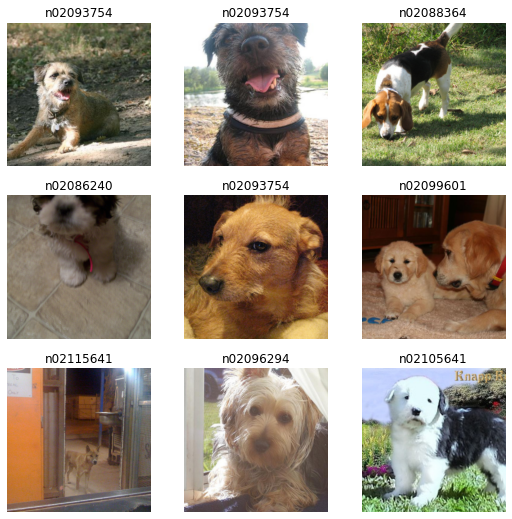

In [5]:
fastai_transform = [[PILImage.create], [parent_label, Categorize()]]
item_transform = [ToTensor(), Resize(256)]
datasets = Datasets(items, fastai_transform)
dataloader = datasets.dataloaders(after_item=item_transform, bs=64)
dataloader.show_batch()

Загрузим словарь, отображающий номерные метки пород в читаемые имена.

In [6]:
import json

with open('breed_labels.json') as json_file:
    breed_labels = json.load(json_file)

breed_labels

{'n02086240': 'Shih-Tzu',
 'n02087394': 'Rhodesian ridgeback',
 'n02088364': 'Beagle',
 'n02089973': 'English foxhound',
 'n02093754': 'Border terrier',
 'n02096294': 'Australian terrier',
 'n02099601': 'Golden retriever',
 'n02105641': 'Old English sheepdog',
 'n02111889': 'Samoyed',
 'n02115641': 'Dingo'}

Создадим новый dataloader

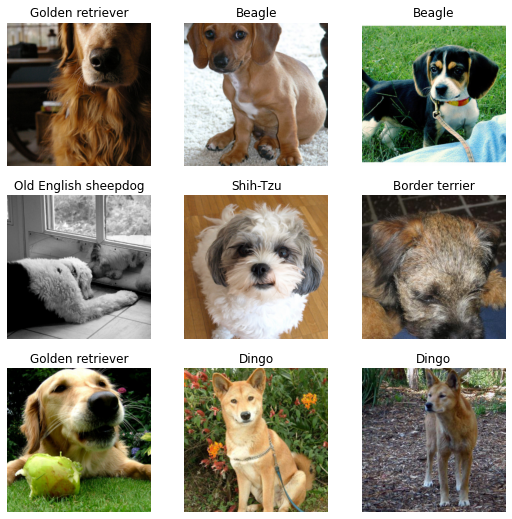

In [7]:
fastai_transform = [[PILImage.create], [parent_label, breed_labels.__getitem__, Categorize()]]
split_idx = GrandparentSplitter(valid_name='val')(items)

datasets = Datasets(items, fastai_transform, splits=split_idx)
batch_transform = [FlipItem(), RandomResizedCrop(256, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dataloader = datasets.dataloaders(after_item=item_transform, 
                                  after_batch=batch_transform, 
                                  bs=64)
dataloader.show_batch()

Загрузим предобученный [XResNet](https://arxiv.org/abs/1812.01187) с функцией активации [Mish](https://arxiv.org/abs/1908.08681v1) и [Self-Attention](https://arxiv.org/abs/1805.08318).

Меняем количество выходных классов на 10, т.к. модель предобучена на ImageNet (1000 классов).

In [8]:
model = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

Функция для замены MaxPool слоев на [MaxBlurPool](https://arxiv.org/pdf/1904.11486.pdf)

In [9]:
from kornia.filters.blur_pool import MaxBlurPool2D

def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = MaxBlurPool2D(3)
            model._modules[name] = layer_new

    return model

In [10]:
model = convert_MP_to_blurMP(model, nn.MaxPool2d)

Для оптимизации используется [ranger](https://arxiv.org/abs/1908.03265)

In [13]:
learn = Learner(dataloader, model=model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, opt_func=ranger)

Learning rate scheduler Fit-Flat-Cosine.

In [ ]:
# Train locally
epochs = 5
lr = 4e-3
learn.fit_flat_cos(epochs, lr)

# Load pretrained
# model_path = f'models/xresnet50.pt'
# model.load_state_dict(torch.load(model_path))

Я обучал модель в [colab](https://colab.research.google.com/drive/1787evNp1XP9WvK01ibh_9lEGPFqWufXG?usp=sharing), там выделяется Tesla T4 c 16 GB видеопамяти (дома GTX 1660 6GB).

Колонка accuracy показывает [validation accuracy](https://forums.fast.ai/t/training-loss-and-training-set-accuracy/14302/7).

<div>
<img src="images/xres_training.png" width="400"/>
</div>


Обучение xresnet50 на изображениях размером 256х256 батчами по 64 требует почти 15 GB видеопамяти:
<div>
<img src="images/xres_gpu.png" width="700"/>
</div>

График функций потерь:

In [ ]:
learn.recorder.plot_loss()

<div>
<img src="images/xres_loss.png" width="400"/>
</div>

Confusion matrix:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize =(12, 12), dpi=60)

<div>
<img src="images/xres_conf.png" width="700"/>
</div>

Наиболее частые ошибки

In [ ]:
interp.most_confused(min_val=20)

Посмотрим фото этих пород:

In [15]:
# invert numbers and breed names in breed_labels dict
breed_labels_inv = {value: key for key, value in breed_labels.items()}
breed_labels_inv

{'Shih-Tzu': 'n02086240',
 'Rhodesian ridgeback': 'n02087394',
 'Beagle': 'n02088364',
 'English foxhound': 'n02089973',
 'Border terrier': 'n02093754',
 'Australian terrier': 'n02096294',
 'Golden retriever': 'n02099601',
 'Old English sheepdog': 'n02105641',
 'Samoyed': 'n02111889',
 'Dingo': 'n02115641'}

In [16]:
# look at images path
str(items[0])

'/home/boris/.fastai/data/imagewoof2/train/n02089973/n02089973_55.JPEG'

In [17]:
def breed_img(num_label):
    """Show images of a given breed"""
    
    # get path to train directory
    train_path = str(items[0]).split('train')[0] + 'train'
    
    # images of given breed
    breed_path = f'{train_path}/{num_label}'
    
    # make dataset
    breed_items = get_image_files(breed_path) 
    breed_dts = Datasets(breed_items, fastai_transform)
    breed_dls = breed_dts.dataloaders(after_item=item_transform, 
                                      after_batch=batch_transform, 
                                      bs=9)
    
    breed_dls.show_batch()

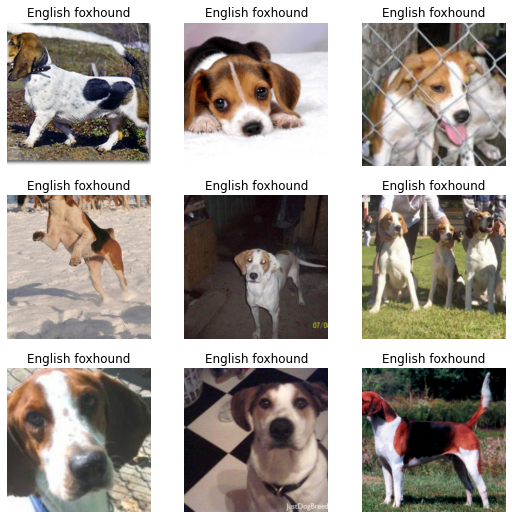

In [18]:
breed1, breed2 = 'English foxhound', 'Beagle'

breed_img(breed_labels_inv[breed1])

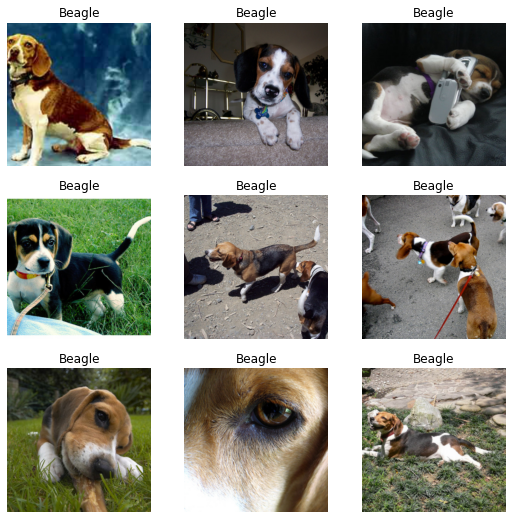

In [19]:
breed_img(breed_labels_inv[breed2])

English foxhound и Beagle действительно очень похожи

### Vision Transformer

Leaderboard Imagewooof обновлялся в 2020. На данный момент топ [leaderboard'a ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet) заполнен Трансформерами.
Загрузим предобученный трансформер и дообучим его на ImageWoof. 

Ссылка на репозиторий:
https://github.com/rwightman/pytorch-image-models

In [20]:
import timm

model = timm.create_model('vit_large_patch16_224', 
                          pretrained=True, 
                          drop_rate=0.2,
                          attn_drop_rate=0.2, 
                          num_classes=10)

In [21]:
# resize images to 224x224 and change batch size to 8
item_transform = [ToTensor(), Resize(224)]
batch_transform = [FlipItem(), RandomResizedCrop(224, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dataloader = datasets.dataloaders(after_item=item_transform, 
                                  after_batch=batch_transform, 
                                  bs=8)

learn = Learner(dataloader, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

Colab notebook: https://colab.research.google.com/drive/1X8bF_OliMbhXSbBDmF5_xDP9sOVCTKoQ?usp=sharing

Пробовал обучать до 10 эпох подряд, макимальная точность (validation accuracy) всегда колеблется вокруг 0.93. По какой-то причине такая точность часто достигается уже после первой итерации обучения и затем падает.

In [ ]:
epochs = 1
learn.fit_one_cycle(epochs, lr_max=1e-4)

<div>
<img src="images/vit_training.png" width="400"/>
</div>


Vision Tansformer требует около 10 GB
<div>
<img src="images/vit_gpu.png" width="700"/>
</div>

Confusion matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

<div>
<img src="images/vit_conf.png" width="700"/>
</div>

Наиболее частые ошибки

In [ ]:
interp.most_confused(min_val=20)

Как видим, Vision Transformer дает лучшую точность. Его и будем использовать для классификации.